In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

stim_dir = "/media/yuhui/LCT/subj01/stimAM/"
os.chdir(stim_dir)

In [2]:
def load_onsets_by_run(fname):
    runs = []
    with open(fname, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                runs.append(np.array([]))
            else:
                runs.append(np.array([float(x) for x in line.split()]))
    return runs

EV_runs = load_onsets_by_run("EV_onset.txt")
OV_runs = load_onsets_by_run("OV_onset.txt")

In [3]:
choice_outcome_all = []
outcome_next_choice_all = []

for EV, OV in zip(EV_runs, OV_runs):
    n_co = min(len(EV), len(OV))
    if n_co > 0:
        choice_outcome_all.append(OV[:n_co] - EV[:n_co])

    n_on = min(len(OV), len(EV) - 1)
    if n_on > 0:
        outcome_next_choice_all.append(EV[1:1+n_on] - OV[:n_on])

choice_outcome_jitter = np.concatenate(choice_outcome_all) if choice_outcome_all else np.array([])
outcome_next_choice_jitter = np.concatenate(outcome_next_choice_all) if outcome_next_choice_all else np.array([])

print("Choice→Outcome N:", len(choice_outcome_jitter))
print("Outcome→NextChoice N:", len(outcome_next_choice_jitter))
print("Choice→Outcome min/median/max:", np.min(choice_outcome_jitter), np.median(choice_outcome_jitter), np.max(choice_outcome_jitter))
print("Outcome→NextChoice min/median/max:", np.min(outcome_next_choice_jitter), np.median(outcome_next_choice_jitter), np.max(outcome_next_choice_jitter))

Choice→Outcome N: 336
Outcome→NextChoice N: 330
Choice→Outcome min/median/max: 2.4989999999999952 5.009999999999991 8.020000000000039
Outcome→NextChoice min/median/max: 2.5 4.5 9.520000000000039


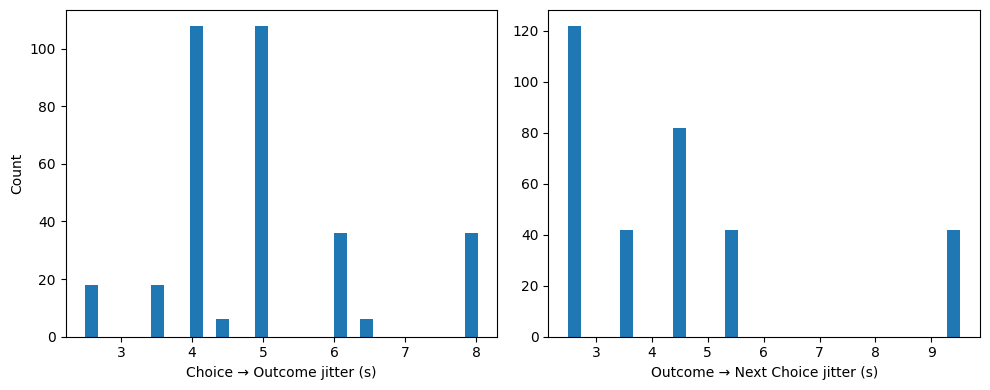

In [4]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(choice_outcome_jitter, bins=30)
plt.xlabel("Choice → Outcome jitter (s)")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(outcome_next_choice_jitter, bins=30)
plt.xlabel("Outcome → Next Choice jitter (s)")

plt.tight_layout()
plt.show()

In [5]:
from scipy.stats import gamma

def spm_hrf(dt, time_length=32.0):
    """SPM-like canonical HRF sampled at dt (seconds)."""
    t = np.arange(0, time_length, dt)
    hrf = gamma.pdf(t, 6) - 0.5 * gamma.pdf(t, 16)
    hrf = hrf / np.max(hrf)
    return hrf

def make_regressor(onsets, run_duration, tr, oversampling=16, hrf_len=32.0):
    """
    Build HRF-convolved regressor for one run.
    - onsets: seconds
    - run_duration: seconds
    - tr: seconds
    - oversampling: e.g., 16
    Returns regressor sampled at TR (length = n_tp).
    """
    dt = tr / oversampling
    n_os = int(np.ceil(run_duration / dt))
    stim = np.zeros(n_os, dtype=float)

    # place impulses
    idx = np.round(onsets / dt).astype(int)
    idx = idx[(idx >= 0) & (idx < n_os)]
    stim[idx] = 1.0

    hrf = spm_hrf(dt, time_length=hrf_len)
    reg_os = np.convolve(stim, hrf, mode="full")[:n_os]

    # downsample to TR grid by averaging within each TR bin
    n_tp = int(np.floor(run_duration / tr))
    reg_os = reg_os[:n_tp * oversampling]
    reg_tr = reg_os.reshape(n_tp, oversampling).mean(axis=1)

    # z-score (optional but often helpful for correlation comparability)
    reg_tr = (reg_tr - reg_tr.mean()) / (reg_tr.std() + 1e-12)
    return reg_tr

In [6]:
TR = 3.083
run_duration = 552.0 # seconds, after discarding initial 2 volumes

corr_choice_outcome = []
corr_outcome_nextchoice = []

for run_i, (EV, OV) in enumerate(zip(EV_runs, OV_runs), start=1):

    # --- build regressors ---
    choice_reg = make_regressor(EV, run_duration, TR, oversampling=16)
    outcome_reg = make_regressor(OV, run_duration, TR, oversampling=16)

    # next-choice regressor = all choices except the first choice onset
    next_choice_reg = make_regressor(EV[1:], run_duration, TR, oversampling=16)

    # --- correlations ---
    r_co = np.corrcoef(choice_reg, outcome_reg)[0, 1]
    r_on = np.corrcoef(outcome_reg, next_choice_reg)[0, 1]

    corr_choice_outcome.append(r_co)
    corr_outcome_nextchoice.append(r_on)

    print(f"Run {run_i}: r(choice,outcome)={r_co:.3f}, r(outcome,next-choice)={r_on:.3f}")

corr_choice_outcome = np.array(corr_choice_outcome)
corr_outcome_nextchoice = np.array(corr_outcome_nextchoice)

print("\nSummary across runs:")
print("Choice–Outcome r:      mean±sd =", corr_choice_outcome.mean(), corr_choice_outcome.std(),
      " median =", np.median(corr_choice_outcome), " range =", (corr_choice_outcome.min(), corr_choice_outcome.max()))
print("Outcome–NextChoice r:  mean±sd =", corr_outcome_nextchoice.mean(), corr_outcome_nextchoice.std(),
      " median =", np.median(corr_outcome_nextchoice), " range =", (corr_outcome_nextchoice.min(), corr_outcome_nextchoice.max()))

Run 1: r(choice,outcome)=-0.055, r(outcome,next-choice)=-0.044
Run 2: r(choice,outcome)=-0.060, r(outcome,next-choice)=-0.044
Run 3: r(choice,outcome)=-0.102, r(outcome,next-choice)=-0.085
Run 4: r(choice,outcome)=-0.053, r(outcome,next-choice)=-0.026
Run 5: r(choice,outcome)=-0.057, r(outcome,next-choice)=-0.062
Run 6: r(choice,outcome)=-0.073, r(outcome,next-choice)=-0.050

Summary across runs:
Choice–Outcome r:      mean±sd = -0.06659458352330508 0.016911273186635205  median = -0.058599823340388484  range = (-0.10155882845647787, -0.05254361359968373)
Outcome–NextChoice r:  mean±sd = -0.05215830985391134 0.018213904562491872  median = -0.047257251078118595  range = (-0.08526527819077126, -0.026499047399487313)
